# Assignment 5

**Submission deadline:**
* **Normal problems: Thursday, 28.05.2020**
* **Bonus problems: Deadline of Assignment 5**

**Points: 10 + 7+ bonus points**


The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Add your solutions to the notebook.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [0]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

In [0]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm


import torch


import tabulate

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [0]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [0]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [0]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [0]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [0]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]

    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2 - q1) # TODO
    
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance

    # Tried to do it with simple division but got 'could not broadcast' error
    r2_pred_norm = np.repeat(np.expand_dims(np.linalg.norm(r2_pred, axis=1), axis=1),
                             300, axis=1)
    vecs_vec_norm = np.repeat(np.expand_dims(np.linalg.norm(vecs.vec, axis=1), axis=1),
                             300, axis=1)
    r2_pred_norm = r2_pred / r2_pred_norm # TODO
    vecs_norm = vecs.vec / vecs_vec_norm  # TODO
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [10]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [11]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Subtask 2: translation through alignment of vector spaces

In [12]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [13]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [0]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [15]:
def translate(W, v, vecs2, vecs2_norm):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    v_pl = np.dot(v, W) / np.linalg.norm(np.dot(v, W))
    idx = np.argmax(v_pl.dot(vecs2_norm.T))
    return vecs2.idx2word[idx]

# Normalizing polish vector embeddings
vecs2_norm = np.repeat(np.expand_dims(np.linalg.norm(ftext_pl.vec, axis=1), axis=1),
                             300, axis=1)
vecs2_norm = ftext_pl.vec / vecs2_norm

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl, vecs2_norm)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

----------  ------------
winning     wygrywając
table       tabelach
wide        szeroki
chris       łągwa
prior       wcześniejszy
root        hypancjum
direction   kierunek
settlement  zasiedlenie
covers      okładka
ships       niszczyciele
troops      odparci
perhaps     pewno
spent       spędził
cars        samochód
affairs     polityka
scott       sebastian
weight      kg/m²
laws        prawo
variety     różnorodny
parents     rodzice
----------  ------------


## Subtask 3: PCA

In [16]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [17]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


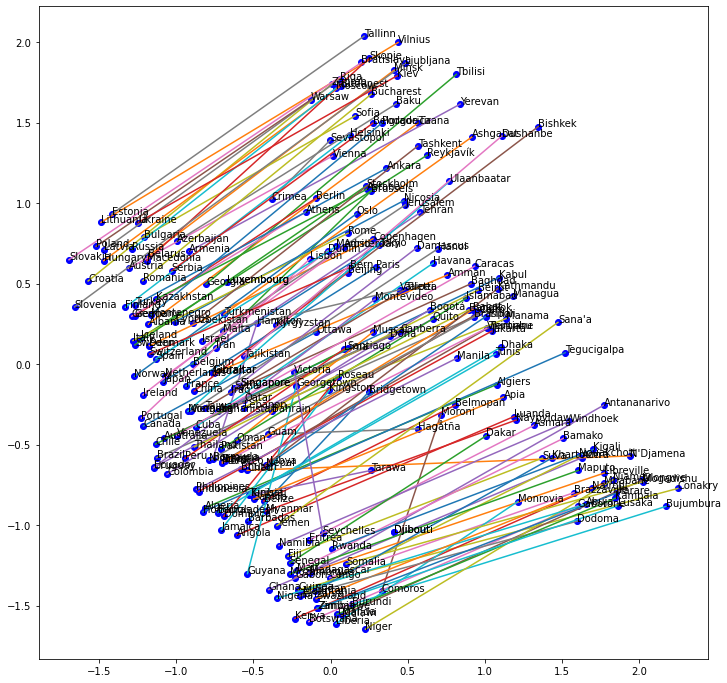

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
pca = PCA(n_components=2)
geo_plain = pca.fit_transform(geo_vecs)

plt.figure(figsize=(12, 12))
for i in range(0, len(geo_plain)//2):
  x = geo_plain[2 * i]
  y = geo_plain[2 * i + 1]
  plt.scatter(x[0], x[1], c='b')
  plt.scatter(y[0], y[1], c='b')
  plt.plot((x[0], y[0]), (x[1], y[1]))
  plt.annotate(geo[2 * i], x)
  plt.annotate(geo[2 * i + 1], y)
plt.show()

# Regularity: Capital is usually around 1.0 point up and 2.0 points right from coutry.

## Subtask 4: PCA vs t-SNE on frequent words

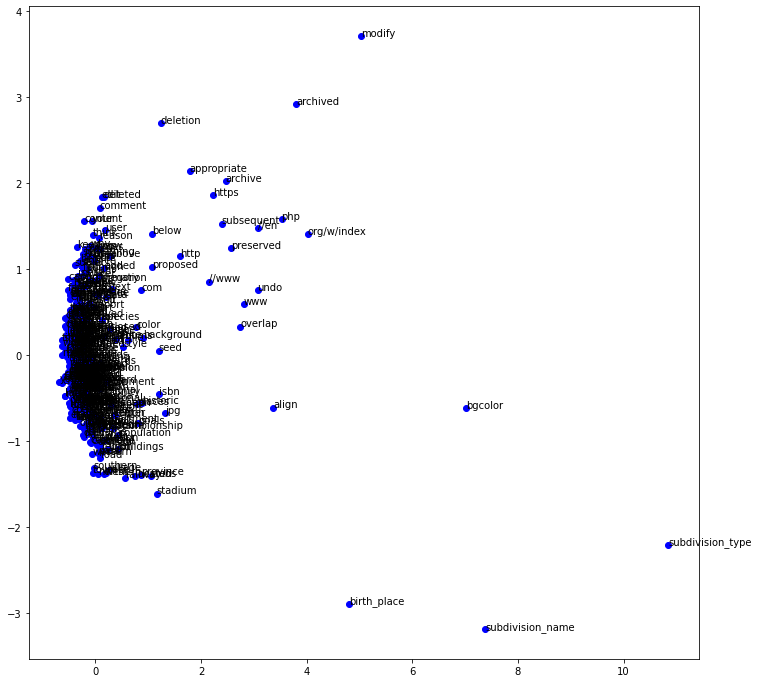

In [19]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#
projections = pca.fit_transform(ftext.vec[top_inds])

plt.figure(figsize=(12, 12))
for point, word in zip(projections, top_words):
  plt.scatter(point[0], point[1], c='b')
  plt.annotate(word, point)
plt.show()

# Not really any regularities, most points are in one place.

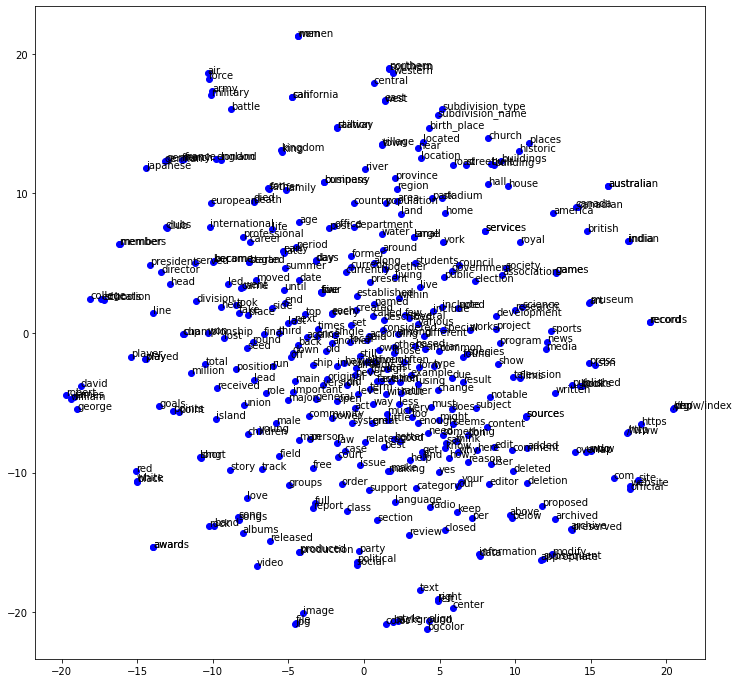

In [29]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
tsne = TSNE(n_components=2)
projections = tsne.fit_transform(ftext.vec[top_inds])

plt.figure(figsize=(12, 12))
for point, word in zip(projections, top_words):
  plt.scatter(point[0], point[1], c='b')
  plt.annotate(word, point)
plt.show()

# Words of similar meaning are close - names are in one area, buildings are in one area etc.

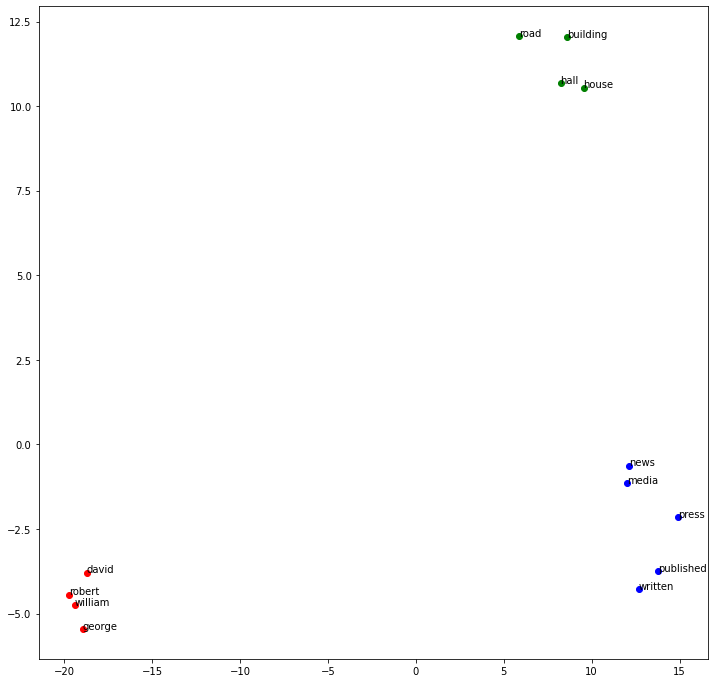

In [31]:
# TODO: zoom in on 3 meaningful clusters
names = {'robert', 'william', 'david', 'george'}
buildings = {'hall', 'house', 'road', 'building'}
media = {'news', 'media', 'press', 'published', 'written'}

plt.figure(figsize=(12, 12))
for point, word in zip(projections, top_words):
  if word in names:
    plt.scatter(point[0], point[1], c='r')
    plt.annotate(word, point)
  if word in buildings:
    plt.scatter(point[0], point[1], c='g')
    plt.annotate(word, point)
  if word in media:
    plt.scatter(point[0], point[1], c='b')
    plt.annotate(word, point)
plt.show()

# Problem 2: kNN Talker [6p + 7bp]

In this exercise you will build a simple chatbot that uses distributed representations of words and sentences to perform a neares neighbor selection of responses.

We have collected two sets of data:
- `./reddit_pairs.txt` of excerpts of [Reddit](https://www.reddit.com/) conversations,
- `./hackernews_pairs.txt` of excertps from [Hackernews](https://news.ycombinator.com/).

The two corpuses are formatted as `tab`-separated pairs of utterances: a `prompt` and a `response`. Successive lines belong to different conversations.

The main idea of the chatbot is to build a representation of the user `input` and of all `prompts` from the corpus. Then select the best (or randomly one of the top few) matches and print the associated `response`.

The key to get the bot working is to create good sentence representations. We will try:
- averaging word embeddings
- using sentence models such as BERT.

### Warning:
The Reddit corpus may contain abusive language, it was not heavily cleaned.

### Tasks
The code below is a starting point, but you can develop you own. The following list suggests some actions to try, along with the points that reflect our subjective hardness. The exercise is worth 6 regular points (i.e. the report, word embedding-based model and BERT-based model), anything on top of it will be counted as a bonus.

1. [MANDATORY] type in a Markdown cell a report of your actions, what did you try, why, what was the result. Show exemplary conversations (they must be probable under your model) [2p].
2. Represent sentences by averaging their word vectors. Properly handle tokenization (you can use regular expressions or e.g. `nltk` library). Describe how you handle lower and upper cased words. Try a fw nearest neighbor selection methods (such as euclidean or cosine distance). See how embedding normalization affects the results (you can normalize individual word vectors, full sentence vectors etc.) [2p]
3. Use the [transformers](https://huggingface.co/transformers) package to load a pretrained BERT model. Use it to represent sentences by e.g. averaging the activations in the last layer [2p].
4. Cherry-pick 3 nice dialogues [1p].
5. Incoportate context: keep a running average of past conversation turns [1p].
6. Do data cleaning, finding rules for good responses [1p].
7. Do profanity cleaning [1p].
8. Try mixing different sentence representation techniques [1p].
9. Try to custer responses to the highest scored prompts. Whic arsponses are more funny: form the largerst or from the smalles cluster? [2p].
10. Implement your own enhancements [?bp].


In [22]:
prompts = []
responses = []
err_lines = []
with open('./hackernews_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])
print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample dialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Failed to parse the following 0 lines: []
Sample dialogue pairs: 
[('Ah, yep, that was the issue.',
  'Yeah, options typically cost the company very little.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Oh, I see.'),
 ("Cross multiplication is a trick to multiply by the 'reciprocal' of the "
  'fraction.',
  'Whaaa?'),
 ('Quite cool.', 'It gets into a pretty philosophical area.'),
 ("If only the packaging smells, then I agree, it's not damaged.",
  'Sounds like entitlement to me.'),
 ("That's what nationalist politics always says.", 'Can you prove that?'),
 ('Misleading title.', 'Not really.'),
 ('Misleading title.',
  'It is not completely misleading to all users but enough for me to say '
  'something.'),
 ('Why the hell is this getting downvoted?',
  "Because it's clear the person he's responding to understood that "
  'relationship.'),
 ("There's a web without ads.",
  'This just came to mind when you mentioned "ad tax".'),
 ('God 

In [0]:
class BasicEncoder:
    def encode(self, sentence):
        # this is a base class!
        raise NotImplementedError

    def encode_corpus(self, sentences):
        ret = [self.encode(sentence) for sentence in tqdm(sentences)]
        return np.vstack(ret)

The code below implements a simple baseline: we encode each sentence as a sparse vector which sums word occurrences.

In [24]:
class OneHotEncoder(BasicEncoder):
    def __init__(self, sentences):
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer()
        self.vectorizer.fit(sentences)
    
    def encode(self, sentence):
        return self.vectorizer.transform([sentence])[0]

    def encode_corpus(self, sentences):
        # Override because sklearn already works on batches
        encodings = self.vectorizer.transform(sentences)
        # Note: this code needs to handl the scipy sparse matrix
        # which has subtle differences with numpy ndarrays
        norms = np.array((encodings.power(2)).sum(1))**0.5
        encodings = encodings.multiply(1.0 / norms)
        return encodings

encoder = OneHotEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Deal with encodings being sparse matrices. Word2vecs will not have the pecularities
scores = (encodings @ enc.T).toarray().ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

1.0 Question. : In a sense 'maybe not'.
1.0 Linux? : Unfortunately not.
1.0 Windows? : Unix based systems
1.0 Question. : This is a good question!
0.8017837257372732 Hardware or software or technique or best practices... : Mobile phones that still work when you drop them.
0.8017837257372732 Hardware or software or technique or best practices... : Floppy disk and cd/dvd drives!
0.8017837257372732 Hardware or software or technique or best practices... : Building your own desktop.
0.8017837257372732 Hardware or software or technique or best practices... : Extreme programming.
0.8017837257372732 Hardware or software or technique or best practices... : Zip drives.
0.8017837257372732 Hardware or software or technique or best practices... : It can all go.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [25]:
import random
# TODO: build a simple dialogue system using these k-neares neighbor matches, 
# perform a few test conversations

num_tests = 2
len_conv  = 5
K = 3
for i in range(num_tests):
    # Random line beginning conversation
    rand_beginning = random.randint(0, len(prompts) - 1)
    prompt = prompts[rand_beginning]
    print("Conversation {}:".format(i))
    for j in range(len_conv):
        enc = encoder.encode(prompt)
        scores = (encodings @ enc.T).toarray().ravel()
        top_idx = scores.argsort()[-10:][::-1]
        # Print prompt and best 3 answers
        print("Prompt:\t", prompt)
        for k, idx in enumerate(top_idx[:3]):
            print("Answer {} with score {:.1f} is:\t{}".format(k, scores[idx], responses[idx]))

        # Select next prompt as nearest neighbour...
        # prompt = responses[top_idx[0]]
        # or random from K nearest neighbours
        prompt = responses[top_idx[random.randint(0, K-1)]]
    print("----------------------------")

Conversation 0:
Prompt:	 Please, don't make me resize my browser for a demo, add a screenshot.
Answer 0 with score 3.3 is:	Hey, dev here.
Answer 1 with score 1.5 is:	Sorry about that!
Answer 2 with score 1.4 is:	OK, just didn't want to add to the clutter if it was unhelpful.
Prompt:	 OK, just didn't want to add to the clutter if it was unhelpful.
Answer 0 with score 2.2 is:	Thanks, added.
Answer 1 with score 2.1 is:	I agree.
Answer 2 with score 2.1 is:	I second all of the above.
Prompt:	 I agree.
Answer 0 with score 1.0 is:	It is nauseating because it's a 1000 word humblebrag.
Answer 1 with score 1.0 is:	I'm not sure I agree.
Answer 2 with score 1.0 is:	I agree.
Prompt:	 I'm not sure I agree.
Answer 0 with score 1.7 is:	I also know plenty of people who find  lack  of choice debilitating.
Answer 1 with score 1.5 is:	I believe you completely.
Answer 2 with score 1.5 is:	Fair enough.
Prompt:	 Fair enough.
Answer 0 with score 1.4 is:	To be honest, I actually think you were right after all.

## One-hot encoding conclusions

### Conversation length
I tried various lengths and checked few conversations. Usually bot is able to more or less stay on topic for about 1-3 dialogues, but then the answer is something vague like for example:
> Without a contract, would it be hard(er) to sell the debt?
>
> 100%

Because bot doesn't keep track of previous topic but sees only the last answer, conversation drastically changes topic at that point and again for 1-3 responses it stays on that subject.

### Selecting answer
Instead of selecting best answer as the next prompt I tried to select random from K nearest neighbours for K=3,4,5. While at some cases it helps, often it makes conversation more random, because usually one of the best answers is something neutral like "Yes.". That  gives us conversations like this:
> I am curious.
>
>	yes        *(third answer)*
>
> 100% agreed.    *(first answer)*
>
> Also happens with religion. *(third answer)*
>
> There is no similarity between that and religion.    *(second answer)*
>
>	Here's the thing.     *(third answer)*

And so on. Beautiful example how one can talk about nothing for a really long time.

In [33]:
class Word2VecEncoder(BasicEncoder):
    def __init__(self, vecs):
        self._vecs = vecs
        self.zeros = np.zeros(len(vecs.vec[0]))
        self.translate_lower = {}
        for word in vecs.word2idx:
          self.translate_lower[word.lower()] = word
        
    def _get_vec(self, word):
        # Find the vector for word, or use a suitbale out-of-vocabulary vector
        # For extra points try backing off to a lowercased dictionary
        
        word = word.lower()   # lowercase all words (optional)
        if word in self.translate_lower:
            word_vec = self._vecs.vec[self._vecs.word2idx[self.translate_lower[word]]]
        else:
            return self.zeros
        # word_vec = word_vec / np.linalg.norm(word_vec) # word vector normalization (optional)
        return word_vec

    def encode(self, sentence):
        ret = np.zeros(self._vecs.vec.shape[1])
        for token in nltk.tokenize.word_tokenize(sentence):
            word_vec = self._get_vec(token)
            ret += word_vec
        ret /= (np.linalg.norm(ret) + 1e-5)
        return ret

encoder = Word2VecEncoder(word2vec)
encodings = encoder.encode_corpus(prompts)

In [34]:
num_tests = 2
len_conv  = 5
K = 3
for i in range(num_tests):
    # Random line beginning conversation
    rand_beginning = random.randint(0, len(prompts) - 1)
    prompt = prompts[rand_beginning]
    print("Conversation {}:".format(i))
    for j in range(len_conv):
        prompt_enc = encoder.encode(prompt)

        # Cosine distance
        scores = prompt_enc.dot(encodings.T)
        top_idx = scores.argsort()[-10:][::-1]

        # Euclidean distance
        # scores = ((encodings - prompt_enc) * (encodings - prompt_enc)).sum(axis=1)
        # top_idx = scores.argsort()[:10]

        # Print prompt and best 3 answers
        print("Prompt:\t", prompt)
        for k, idx in enumerate(top_idx[:3]):
            print("Answer {} with score {:.1f} is:\t{}".format(k, scores[idx], responses[idx]))

        # Select next prompt as nearest neighbour...
        prompt = responses[top_idx[0]]
        # or random from K nearest neighbours
        # prompt = responses[top_idx[random.randint(0, K-1)]]
    print("----------------------------")

Conversation 0:
Prompt:	 This essay has a thesis, and gender isn't it.
Answer 0 with score 1.0 is:	He's not just showing appreciation.
Answer 1 with score 0.9 is:	Hone in is so common that it's now listed.
Answer 2 with score 0.9 is:	No one care about race.
Prompt:	 He's not just showing appreciation.
Answer 0 with score 0.9 is:	What I'm saying is that I have never heard this corporate master garbage.
Answer 1 with score 0.9 is:	But not sufficiently unhappy to do anything about it.
Answer 2 with score 0.9 is:	Perhaps he is more unhappy about being photographed.
Prompt:	 What I'm saying is that I have never heard this corporate master garbage.
Answer 0 with score 1.0 is:	Your own ignorance of history is on you alone.
Answer 1 with score 1.0 is:	There is literally nothing objectively "meaningful"  to do  that we know of.
Answer 2 with score 0.9 is:	Okay, I was wrong  again .
Prompt:	 Your own ignorance of history is on you alone.
Answer 0 with score 0.9 is:	That's the rub, isn't it.
Answ

## Word2vec encoding conclusions

## Lowercasing

In my code lowercasing was meant as a tool to find more words in a vocabulary, because words that are not in the vocabulary do not count towards sentence embedding. As a measure of success of lowercasing I counted number of words found in vocabulary (word2vec.word2idx) out of all 484567 words in all prompts.

Without any lowercasing amount of words found was 365644. When words were lowercased, 364503 of them were found, so it decreased performance. It was due to the fact that a) vocabulary itself isn't lowercased and b) some words like "I" are in vocabulary only uppercased.

Therefore I created *self.translate_to_lower* which is a dict translating all words in vocabulary from lowercased to normal. Together with lowercasing input words it increased the amount of hits to 401845 (increase by about 10%). It means more words contribute to sentence score what should result in more accurate predictions.

## Embedding normalization

Sentence embedding normalization was already added in code provided to us and from what I see it is beneficial to turn it in just as it was good to have word embedding normalization in task 1.

I tried to normalize also word embeddings in *self._get_vec* method and to my surprise it produced worse results. My guess is that some words (like "procastinate", "python") contribute more to a meaning of a sentence than other (like "is", "there") and therefore should "drag" embedding vector more than those less meaningful. Normalizing word vectors makes all words contribute equally to the sentence meaning and therefore the most meaningful ones can get lost in the process.

In conclusion: it is better not to use word embedding normalization in this case.

## Nearest neighbour selection methods

### Cosine distance

Using cosine distance as a tool to select nearest neighbours turns out to be a good idea. Few options selected with highest score are usually good choices in that conversation and their score is close to 1.0 (so model is confident in its choices). As first option usually isn't much better that couple next of them, it doesn't really matter whether we choose first option or random among first few ones. Conversations produced are sometimes quite natural:

> Why would you have sshd running on your workstation in the first place?
>
> It's irreplacable when one occasionally works from home.
>
>	Do you have a source or you're assuming?
>
>	I don't have any source besides myself.
>
>	This has been my experience too.

Problems occur (just as in previous method) when chosen answer doesn't say anything about topic of discussion (like "I agree."). Bot doesn't keep context then and topic shifts in another direction.

### Euclidean distance

Using euclidean distance also isn't a bad choice, but conversations seem to float around the subject more, as if the people talking didn't really hear each other. What's more, options second, third etc. are much less accurate than the first, so it's better to always take the nearest neighbour.

>	The journey is as much fun as the end product.
>
> This is the problem, robots are killing the journey.
>
> You know people still walk right?
>
>	Honestly, I don't know.
>
> can you go into more detail about your "experience"?
>
> I think his point was, that you can only go so far pleasing yourself.

Problems with multi-purpose answers from cosine distance appear also in this case, as we still don't keep context of discussion.

In [59]:
from transformers import BertTokenizer, BertModel

class BERTEncoder(BasicEncoder):
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
        self.model = BertModel.from_pretrained("bert-base-cased")

    def encode(self, tensor_batch):
        tensor_ret = self.model(tensor_batch)[0].flatten(1,2).detach()
        return tensor_ret.numpy()

    def encode_corpus(self, sentences):
        # Override because without batching it works painfully slow.
        ret = []
        batch = []
        for sentence in tqdm(sentences):
            token = self.tokenizer.encode(sentences[i + j])
            while len(token) < 40:
                token.append(0)
            batch.append(token)
            if len(batch) == 110:
                tensor_enc = torch.tensor(batch)
                enc = self.encode(tensor_enc)
                for line in enc:
                    ret.append(line)
                batch = []
        return ret

encoder = BERTEncoder()
encodings = encoder.encode_corpus(prompts)

In [0]:
encodings = np.vstack(encodings)

In [74]:
num_tests = 1
len_conv  = 5
K = 3
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
for i in range(num_tests):
    # Random line beginning conversation
    rand_beginning = random.randint(0, len(prompts) - 1)
    prompt = prompts[rand_beginning]
    print("Conversation {}:".format(i))
    for j in range(len_conv):
        token = tokenizer.encode(prompt)
        while len(token) < 40:
            token.append(0)
        prompt_enc = encoder.encode(torch.tensor(token).unsqueeze(0))

        scores = prompt_enc.dot(encodings.T).flatten()
        top_idx = scores.argsort()[-10:][::-1]

        # Print prompt and best 3 answers
        print("Prompt:\t", prompt)
        for k, idx in enumerate(top_idx[:3]):
            print("Answer {} with score {:.1f} is:\t{}".format(k, scores[idx], responses[idx]))

        # Select next prompt as nearest neighbour...
        prompt = responses[top_idx[0]]
        # or random from K nearest neighbours
        # prompt = responses[top_idx[random.randint(0, K-1)]]
    print("----------------------------")

Conversation 0:
Prompt:	 I've always wondered this.
Answer 0 with score 10345.5 is:	Ah, you're right.
Answer 1 with score 10345.5 is:	They aren't.
Answer 2 with score 10345.5 is:	Fair point, and constructive as well.
Prompt:	 Ah, you're right.
Answer 0 with score 10307.7 is:	thanks!
Answer 1 with score 10307.7 is:	What food pyramid?
Answer 2 with score 10307.7 is:	It's not like "group work" doesn't exist once you get to the working world.
Prompt:	 thanks!
Answer 0 with score 9979.9 is:	Ah, you're right.
Answer 1 with score 9979.9 is:	They aren't.
Answer 2 with score 9979.9 is:	Fair point, and constructive as well.
Prompt:	 Ah, you're right.
Answer 0 with score 10307.7 is:	thanks!
Answer 1 with score 10307.7 is:	What food pyramid?
Answer 2 with score 10307.7 is:	It's not like "group work" doesn't exist once you get to the working world.
Prompt:	 thanks!
Answer 0 with score 9979.9 is:	Ah, you're right.
Answer 1 with score 9979.9 is:	They aren't.
Answer 2 with score 9979.9 is:	Fair point,

## Nice dialogues
### Conversation 1:
> Webmail now seems to have disappeared.
>
>	Perhaps they read hn?
>
> Perhaps?
>
>	yeah
### Conversation 2:
> Defense lawyers aren't free.
>
> You cannot be denied one.
>
> A third party cookie has a specific meaning.
>
> Nobody has mentioned third party cookies except you.
>
> You can't be further from the truth.
### Conversation 3:
> Whelp, you're missing out on some interesting stuff, man.
>
>Like?
>
> @nicolewhite algebra.js looks really interesting.
>
> Sure.
>
> Yes, simplicity counts for a lot.
> There were good reasons that the code was written the way it was.
>
> Thanks for the explanation.

In [0]:
encoder = Word2VecEncoder(word2vec)
encodings = encoder.encode_corpus(prompts)

In [0]:
num_tests = 1
len_conv  = 10
K = 3
for i in range(num_tests):
    # Random line beginning conversation
    rand_beginning = random.randint(0, len(prompts) - 1)
    prompt = prompts[rand_beginning]
    prompt_avg = [0.0 for _ in range(len(encodings[0]))]
    print("Conversation {}:".format(i))
    for j in range(len_conv):
        prompt_enc = encoder.encode(prompt)
        # Keeping running average
        prompt_avg = (prompt_avg + prompt_enc) / 2

        # Cosine distance
        scores = prompt_avg.dot(encodings.T)
        top_idx = scores.argsort()[-10:][::-1]

        # Print prompt and best 3 answers
        print("Prompt:\t", prompt)
        for k, idx in enumerate(top_idx[:3]):
            print("Answer {} with score {:.1f} is:\t{}".format(k, scores[idx], responses[idx]))

        # Select next prompt as nearest neighbour...
        # prompt = responses[top_idx[0]]
        # or random from K nearest neighbours
        prompt = responses[top_idx[random.randint(0, K-1)]]
    print("----------------------------")